In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import ast
from datetime import datetime
from enum import Enum
from typing import List, Optional, Tuple, Dict, Any
import gym
from gym import spaces
from stable_baselines3 import SAC, PPO, A2C, DDPG, TD3, DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure
from tqdm.notebook import tqdm
import torch
from torch import nn
import csv

### Data Model Classes

In [31]:
class Customer:
    def __init__(self, idx: int, zip_code: int, city: str, state: str, num_products: int):
        self.idx = idx
        self.zip_code = zip_code
        self.city = city
        self.state = state
        self.views = [0] * num_products
        self.likes = [0] * num_products
        self.purchases = [0] * num_products
        self.ratings = [0] * num_products

In [32]:
class Category:
    def __init__(self, idx: int, name: str, desc: str):
        self.idx = idx
        self.name = name
        self.desc = desc

In [33]:
class Product:
    def __init__(self, idx: int, name: str, desc: str, long_desc: str, category: Category, price: float) -> None:
        self.idx = idx
        self.name = name
        self.desc = desc
        self.long_desc = long_desc
        self.category = category
        self.price = price

In [34]:
class InteractionType(Enum):
    NONE = "none"
    VIEW = "view"
    LIKE = "like"
    BUY = "buy"
    RATE = "rate"
    EXIT = "exit"
    SESSION_START = "session_start"
    SESSION_CLOSE = "session_close"


class Interaction:
    def __init__(
        self,
        idx: str,
        timestamp: datetime,
        product_idx: int,
        customer_idx: int,
        type: InteractionType,
        value: float = 0.0,
        review_score: Optional[int] = None,
    ):
        self.idx = idx
        self.timestamp = timestamp
        self.product_idx = product_idx
        self.customer_idx = customer_idx
        self.type = type
        self.value = value
        self.review_score = review_score

### Data Loader Functions

In [35]:
data_dir = "../data/cleaned/"

In [36]:
def load_customers(num_products: int, interactions: List[Interaction], idxs: List[int] = []) -> List[Customer]:
    customer_df = pd.read_csv(f"{data_dir}Customer.csv")
    if idxs:
        customer_df = customer_df[customer_df["idx"].isin(idxs)]

    # Create a dictionary to hold customer interactions
    customer_interactions = {}
    for interaction in interactions:
        cust_id = interaction.customer_idx
        if cust_id not in customer_interactions:
            customer_interactions[cust_id] = {
                "views": [0] * num_products,
                "likes": [0] * num_products,
                "purchases": [0] * num_products,
                "ratings": [0] * num_products,
            }

        product_idx = interaction.product_idx
        if interaction.type == InteractionType.VIEW:
            customer_interactions[cust_id]["views"][product_idx] += 1
        elif interaction.type == InteractionType.LIKE:
            customer_interactions[cust_id]["likes"][product_idx] += 1
        elif interaction.type == InteractionType.BUY:
            customer_interactions[cust_id]["purchases"][product_idx] += 1
            customer_interactions[cust_id]["ratings"][product_idx] = interaction.review_score if interaction.review_score else 0
        elif interaction.type == InteractionType.RATE:
            customer_interactions[cust_id]["ratings"][product_idx] = interaction.review_score if interaction.review_score else 0

    customers = []
    for _, row in customer_df.iterrows():
        cust_id = row["idx"]
        # Initialize with interaction data if available
        views = customer_interactions.get(cust_id, {}).get("views", [0] * num_products)
        likes = customer_interactions.get(cust_id, {}).get("likes", [0] * num_products)
        purchases = customer_interactions.get(cust_id, {}).get("purchases", [0] * num_products)
        ratings = customer_interactions.get(cust_id, {}).get("ratings", [0] * num_products)

        # Create customer instance
        customer = Customer(idx=cust_id, zip_code=row["zip_code"], city=row["city"], state=row["state"], num_products=num_products)

        # Assign interaction data
        customer.views = views
        customer.likes = likes
        customer.purchases = purchases
        customer.ratings = ratings
        customers.append(customer)

    return customers

In [37]:
def load_categories(idxs: List[int] = []) -> List[Category]:
    category_df = pd.read_csv(f"{data_dir}Category.csv")
    if idxs:
        category_df = category_df[category_df["idx"].isin(idxs)]

    categories = [Category(idx=row["idx"], name=row["name"], desc=row["desc"]) for _, row in category_df.iterrows()]
    return categories

In [38]:
def load_products(idxs: List[int] = []) -> Tuple[List[Product], float]:
    product_df = pd.read_csv(f"{data_dir}Product.csv")
    category_df = pd.read_csv(f"{data_dir}Category.csv")

    # Create a dictionary to map category IDs to Category objects
    category_map = {row["idx"]: Category(idx=row["idx"], name=row["name"], desc=row["desc"]) for _, row in category_df.iterrows()}

    if idxs:
        product_df = product_df[product_df["idx"].isin(idxs)]

    products = [
        Product(
            idx=row["idx"],
            name=row["name"],
            desc=row["desc"],
            long_desc=row["long_desc"],
            category=category_map.get(row["category_num_id"]),
            price=row["price"],
        )
        for _, row in product_df.iterrows()
    ]

    # Calculate the maximum price for setting price levels
    max_price = product_df["price"].max()
    return products, max_price

In [39]:
def load_interactions(idxs: List[int] = [], customer_idxs: List[int] = [], k: int = 0) -> List[Interaction]:
    interaction_df = pd.read_csv(f"{data_dir}Interaction.csv")

    # Filter by index or customer if specified
    if idxs:
        interaction_df = interaction_df[interaction_df["idx"].isin(idxs)]
    elif customer_idxs:
        interaction_df = interaction_df[interaction_df["customer_idx"].isin(customer_idxs)]

    # Limit to the last k interactions, sorted by timestamp
    if k > 0:
        interaction_df = interaction_df.sort_values(by="timestamp", ascending=False).head(k)

    # Process each interaction with proper parsing
    interactions = [
        Interaction(
            idx=row["idx"],
            timestamp=datetime.strptime(row["timestamp"], "%Y-%m-%d %H:%M:%S"),
            customer_idx=row["customer_idx"],
            product_idx=row["product_idx"],
            type=InteractionType(row["type"]),
            value=row["value"],
            review_score=row["review_score"],
        )
        for _, row in interaction_df.iterrows()
    ]
    return interactions

In [40]:
# Initialize Customers and Products
products, max_price = load_products()
num_products = len(products)
interactions = load_interactions()
customers = load_customers(num_products, interactions)

### Custom Environment

In [42]:
class RecommendationEnv(gym.Env):
    def __init__(self, users: List[Customer], products: List[Product], top_k: int, max_price: float, price_interval: int = 500):
        super().__init__()

        self.users = users
        self.products = products
        self.top_k = top_k
        self.user_idx = 0
        self.current_step = 0
        self.categories = load_categories()

        # Set num_price_levels based on max_price and interval
        self.num_price_levels = int(np.ceil(max_price / price_interval))
        self.price_interval = price_interval

        # Define action space
        self.num_products = len(products)
        self.num_categories = len(self.categories)
        self.action_space = spaces.Discrete(self.num_products * self.num_categories * self.num_price_levels)

        # Observation space
        self.observation_space = spaces.Dict(
            {
                "pref_prod": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32),
                "pref_cat": spaces.Box(low=0, high=1, shape=(self.num_categories,), dtype=np.float32),
                "purchase": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32),
                "viewed": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32),
                "liked": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.int32),
                "ratings": spaces.Box(low=0, high=5, shape=(self.num_products,), dtype=np.float32),
                "product": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.uint8),
                "interaction": spaces.Box(low=0, high=1, shape=(len(InteractionType),), dtype=np.uint8),
                "rating": spaces.Box(low=0, high=5, shape=(1,), dtype=np.uint8),
            }
        )

    def decode_action(self, action):
        product_idx = action % self.num_products
        category_idx = (action // self.num_products) % self.num_categories
        price_idx = (action // (self.num_products * self.num_categories)) % self.num_price_levels

        # Convert price_idx to actual price
        price = price_idx * self.price_interval
        return {"product_idx": product_idx, "category_idx": category_idx, "price": price}

    def step(self, action):
        self.current_step += 1
        user = self.users[self.user_idx]

        # Decode action and simulate response
        decoded_action = self.decode_action(action)
        recommended_product = decoded_action["product_idx"]
        interaction_type = random.choice(list(InteractionType))
        rating_value = random.randint(1, 5) if interaction_type == InteractionType.RATE else 0

        # Calculate reward and determine episode end
        reward = self._calculate_reward(interaction_type, rating_value)
        done = interaction_type == InteractionType.SESSION_CLOSE

        # Update observation based on interaction
        obs = self._update_observation(recommended_product, interaction_type, rating_value)

        return obs, reward, done, {}

    def reset(self):
        self.user_idx = np.random.randint(len(self.users))
        self.current_step = 0
        return self._get_observation()

    def _calculate_reward(self, interaction_type, rating_value):
        if interaction_type == InteractionType.NONE:
            return -1
        elif interaction_type == InteractionType.VIEW:
            return 1
        elif interaction_type == InteractionType.LIKE:
            return 3
        elif interaction_type == InteractionType.BUY:
            return 20
        elif interaction_type == InteractionType.RATE:
            return (rating_value - 3) * 2
        elif interaction_type == InteractionType.SESSION_START:
            return 0
        elif interaction_type == InteractionType.SESSION_CLOSE:
            return -1
        return 0

    def _update_observation(self, product_idx, interaction_type, rating_value):
        user = self.users[self.user_idx]

        if interaction_type == InteractionType.VIEW:
            user.views[product_idx] += 1
        elif interaction_type == InteractionType.LIKE:
            user.likes[product_idx] += 1
        elif interaction_type == InteractionType.BUY:
            user.purchases[product_idx] += 1
        elif interaction_type == InteractionType.RATE:
            user.ratings[product_idx] = rating_value

        return self._get_observation()

    def _get_observation(self):
        user = self.users[self.user_idx]
        observation = {
            "pref_prod": self._get_product_preferences(user),
            "pref_cat": self._get_category_preferences(user),
            "purchase": user.purchases,
            "viewed": user.views,
            "liked": user.likes,
            "ratings": user.ratings,
            "product": np.zeros(len(self.products)),
            "interaction": np.zeros(len(InteractionType)),
            "rating": np.array([0]),
        }
        return observation

    def _get_product_preferences(self, user):
        view_pref = np.array(user.views) / 20
        purchase_pref = np.array(user.purchases)
        like_pref = np.array(user.likes) / 15
        rate_pref = (np.array(user.ratings) - 3) / 10
        return view_pref + purchase_pref + like_pref + rate_pref

    def _get_category_preferences(self, user):
        category_pref = np.zeros(len(self.categories))
        for product_idx in range(len(self.products)):
            # Access category ID through the category attribute
            category = self.products[product_idx].category
            if category is not None:
                category_idx = category.idx
                category_pref[category_idx] += user.views[product_idx] + user.purchases[product_idx]
        return category_pref / np.sum(category_pref) if np.sum(category_pref) > 0 else category_pref

    def render(self, mode="human"):
        print(f"Current User Index: {self.user_idx}")
        print(f"Step: {self.current_step}")

    def close(self):
        pass

### Initialize environment

In [43]:
# Initialize the environment with users and products
env = RecommendationEnv(users=customers, products=products, top_k=5, max_price=max_price)

# Wrap the environment for vectorized training
vec_env = make_vec_env(lambda: env, n_envs=4)

c:\Users\farha\miniconda3\envs\rl_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


#### Logging

In [44]:
# Custom callback to log rewards for plotting
class RewardLoggingCallback(BaseCallback):
    def __init__(self, log_file="training_rewards.csv", verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.rewards = []
        self.episode_lengths = []  # Track episode lengths
        self.current_episode_length = 0
        self.log_file = log_file

        # Open the file in write mode and add a header row for the CSV log
        with open(self.log_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Timestep", "Reward"])

    def _on_step(self) -> bool:
        # Increment episode length
        self.current_episode_length += 1

        # Get the reward from the last step
        reward = self.locals.get("rewards")
        if reward:
            reward_value = reward[0]  # Assuming single environment
            self.rewards.append(reward_value)

            # Append the reward and timestep to the CSV file
            with open(self.log_file, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([self.num_timesteps, reward_value])

        # Check if episode is done
        if self.locals.get("dones")[0]:  # Assuming single environment
            self.episode_lengths.append(self.current_episode_length)
            self.current_episode_length = 0

        return True

In [45]:
class EpsilonLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(EpsilonLoggingCallback, self).__init__(verbose)
        self.exploration_rates = []

    def _on_step(self) -> bool:
        # Log the current epsilon value
        if hasattr(self.model, "exploration_rate"):
            self.exploration_rates.append(self.model.exploration_rate)
        return True

In [46]:
# Output directory
output_dir = "./outputs/"

# Set up TensorBoard logging directory
tensorboard_log_dir = f"{output_dir}tensorboard_logs/"
model_save_path = f"{output_dir}dqn_recommender"
os.makedirs(tensorboard_log_dir, exist_ok=True)

# Configure TensorBoard logger
new_logger = configure(tensorboard_log_dir, ["tensorboard"])

### Initialize model

In [47]:
# Initialize SAC model with TensorBoard logging
model = DQN(
    policy="MultiInputPolicy",
    env=env,
    verbose=1,
    learning_rate=1e-3,
    buffer_size=10000,
    batch_size=64,
    learning_starts=1000,
    target_update_interval=500,
    gamma=0.99,
    policy_kwargs=dict(
        net_arch=[256, 256],
        activation_fn=torch.nn.ReLU,
    ),
    tensorboard_log=tensorboard_log_dir,
)

model.set_logger(new_logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [48]:
# Initialize custom callbacks
total_timesteps = 1000

# Callbacks for logging rewards and epsilon values
reward_callback = RewardLoggingCallback(log_file=f"{output_dir}training_rewards.csv")
epsilon_callback = EpsilonLoggingCallback()

In [49]:
# Train the model with both progress and reward logging callbacks
model.learn(
    total_timesteps=total_timesteps,
    callback=[reward_callback, epsilon_callback],
    progress_bar=True,
)

Output()

In [50]:
# Save the trained model
model.save(model_save_path)

### Plots

In [51]:
# Plotting training rewards over timesteps
def plot_training_metrics(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward")
    plt.xlabel("Timesteps")
    plt.ylabel("Reward")
    plt.title("Reward vs. Timesteps")
    plt.legend()
    plt.show()


# Cumulative reward plot
def plot_cumulative_rewards(rewards):
    cumulative_rewards = np.cumsum(rewards)
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_rewards, label="Cumulative Reward")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward vs. Timesteps")
    plt.legend()
    plt.show()


# Moving average of rewards
def plot_moving_average_rewards(rewards, window=50):
    moving_avg_rewards = np.convolve(rewards, np.ones(window) / window, mode="valid")
    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg_rewards, label="Moving Average Reward (Window = {})".format(window))
    plt.xlabel("Timesteps")
    plt.ylabel("Moving Average Reward")
    plt.title("Moving Average of Reward vs. Timesteps")
    plt.legend()
    plt.show()


# Plot episode lengths
def plot_episode_lengths(episode_lengths):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episodes")
    plt.ylabel("Episode Length")
    plt.title("Episode Length vs. Episodes")
    plt.legend()
    plt.show()


# Plot exploration rate over time
def plot_exploration_rate(exploration_rates):
    plt.figure(figsize=(10, 5))
    plt.plot(exploration_rates, label="Exploration Rate")
    plt.xlabel("Timesteps")
    plt.ylabel("Exploration Rate (Epsilon)")
    plt.title("Exploration Rate vs. Timesteps")
    plt.legend()
    plt.show()

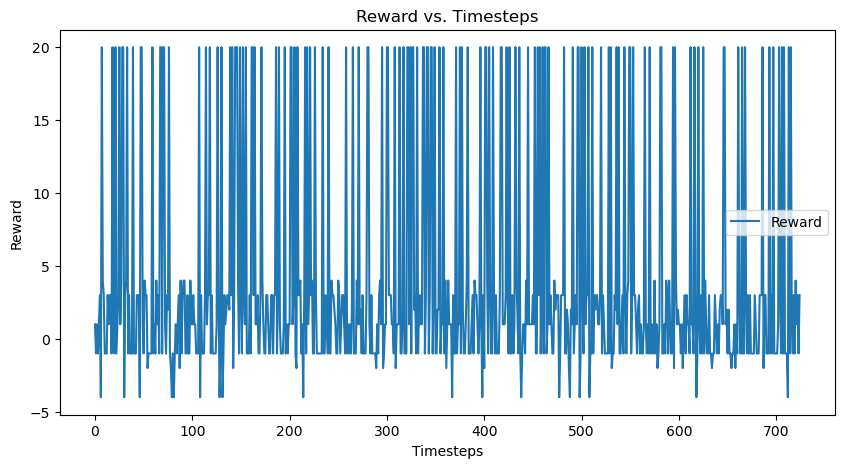

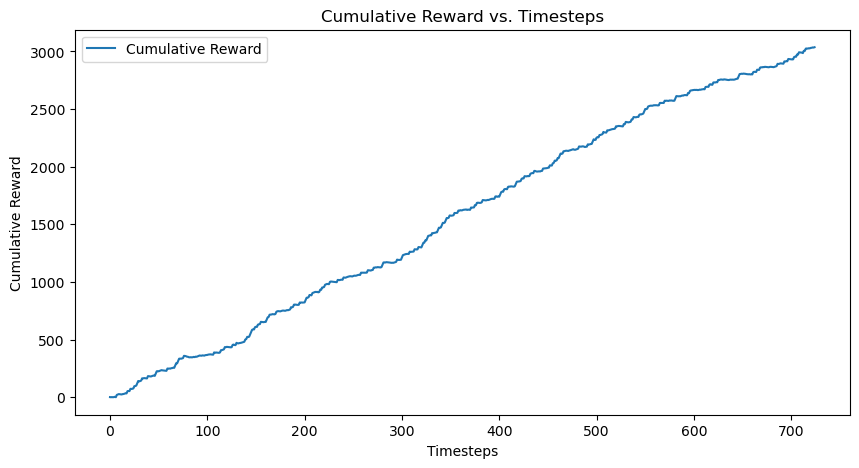

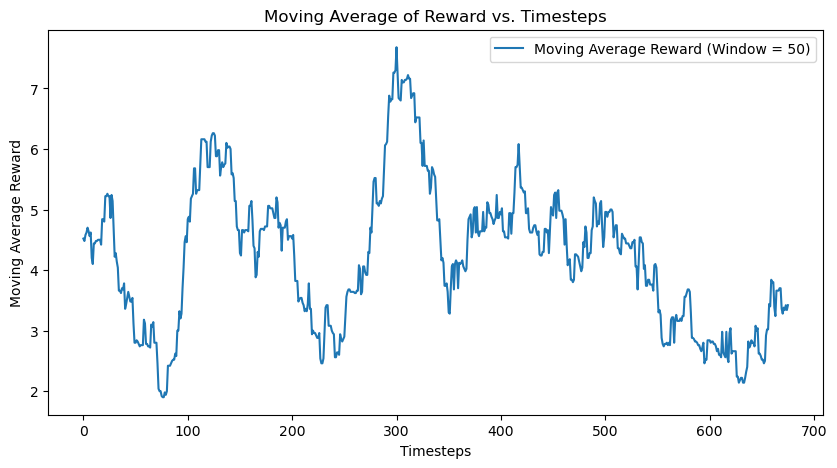

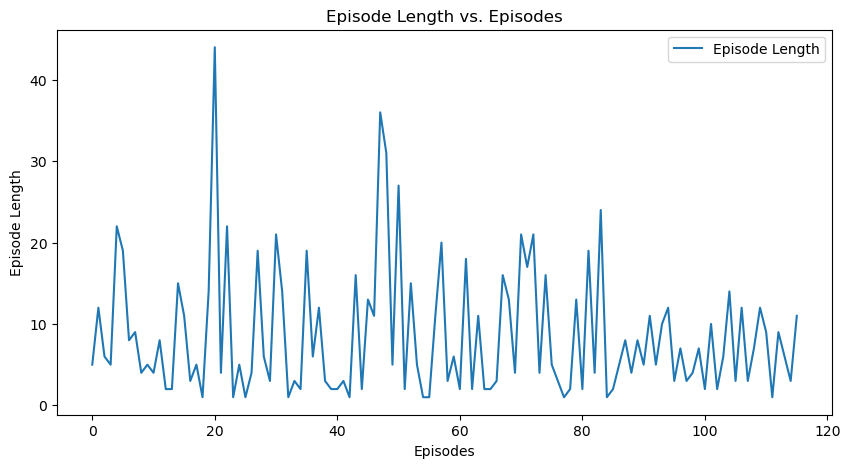

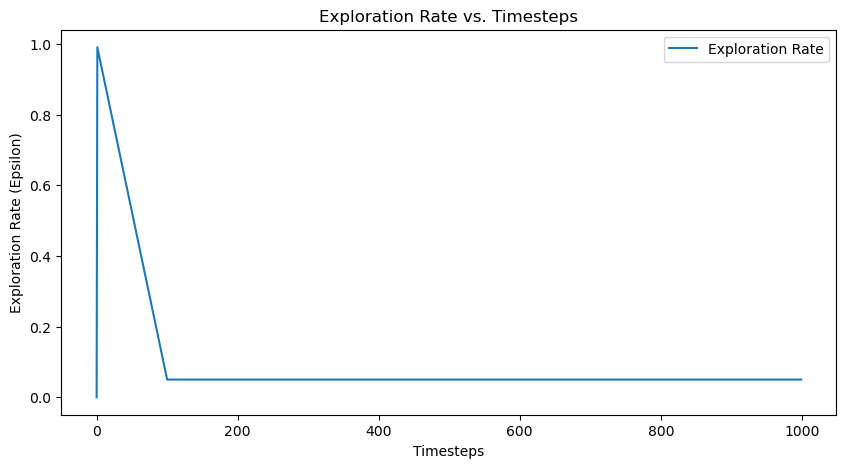

In [52]:
# Plot training rewards
plot_training_metrics(reward_callback.rewards)

# Plot cumulative rewards
plot_cumulative_rewards(reward_callback.rewards)

# Plot moving average of rewards
plot_moving_average_rewards(reward_callback.rewards)

# Plot episode lengths
plot_episode_lengths(reward_callback.episode_lengths)

# Plot exploration rate over time
plot_exploration_rate(epsilon_callback.exploration_rates)